In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm

In [83]:
import mplfinance as mpf

In [210]:
global data_dict

In [205]:
long_table['time'] = pd.to_datetime(long_table['time'])

# 分组并构建字典
data_dict = {}
# 按 stock_id 分组
grouped = long_table.groupby('stock_id')
for stock_id, group_df in grouped:
    # 将 group_df 处理为索引是 time，列是 indicator，值是 value 的 DataFrame
    pivoted = group_df.pivot(index='time', columns='indicator', values='value')
    data_dict[stock_id] = pivoted

In [394]:
def extract_data(df,n):
    '''
    输入：df 代表信号 id和time  n 往前回溯的天数
    输出：一个(n + 1) * 4的df 用于画Kline
    '''
    ans = pd.DataFrame(0,index = range(n + 1),columns = ['open','close','high','low'])
    count = 0
    for row in df.itertuples():
        time = row.time
        stock_id = row.stock_id
        data = data_dict[stock_id]
        data.index = pd.to_datetime(data.index)
        time_index = data.index.get_loc(time)
        base_price = data.loc[time,'open']
        valid_ddff = data.iloc[time_index - n:time_index + 1][['open','close','high','low']].reset_index(drop = True) / base_price
        if not valid_ddff.isna().any().any():
            ans += valid_ddff
            count += 1
        else:
            continue
            
    return ans / count if count != 0 else None

In [2]:
def process_indicator(data, indicator_name):
    # stack()：将列（股票ID）转为行，形成（时间, 股票ID）的二级索引
    long_df = data.stack(dropna = True).reset_index()
    # 重命名列：股票ID、时间、指标值
    long_df.columns = ['stock_id', 'time', 'value']
    # 添加指标类型列（如'post'、'high'）
    long_df['indicator'] = indicator_name
    return long_df

In [136]:
def init_worker(table):
    global shared_table
    shared_table = table
    
def init_worker2(table):
    global trade_date
    trade_date = table

In [140]:
init_worker2(trade_dates)

In [12]:
###预处理 拼成长表
post_data = ff.read('post') * ff.filter0
high_data = ff.read('high') * post_data * ff.filter0
low_data = ff.read('low') * post_data * ff.filter0
close_data = ff.read('close') * post_data * ff.filter0
open_data = ff.read('open') * post_data * ff.filter0
next_uplimit_data = (ff.read('up_limit') * post_data * ff.filter0).shift(-1,axis = 1)
next_open_data = (ff.read('open') * post_data * ff.filter0).shift(-1,axis = 1)


df_high = process_indicator(high_data, 'high')
df_low = process_indicator(low_data, 'low')
df_close = process_indicator(close_data, 'close')
df_open = process_indicator(open_data, 'open')
df_next_uplimit = process_indicator(next_uplimit_data, 'next_uplimit')
df_next_open = process_indicator(next_open_data, 'next_open')

long_table = pd.concat(
    [df_high, df_low, df_close, df_open, df_next_uplimit,df_next_open],
    ignore_index=True
)
long_table['time'] = pd.to_datetime(long_table['time'])
init_worker(long_table)

In [188]:
long_table['time'] = pd.to_datetime(long_table['time'])
init_worker(long_table)

In [5]:
def climax_find(df):
    '''
    找到局部极值点
    ##输入：DataFrame index是日期 columns是high low open close
    ##输出：DataFrame index是日期 columns是high low open close peak_high peak_low
    # 创建peak列，默认值为NaN
    '''
    
    df['peak_high'] = False
    df['peak_low'] = False
    
    for i in range(len(df)):
        # 确定查找范围（防止越界）
        start = max(0, i - 1)
        end = min(len(df), i + 2)
        
        # 使用loc通过标签索引列
        current_high = df.loc[df.index[i], 'high']
        range_highs = df.loc[df.index[start:end], 'high']
        
        # 判断当前是否为局部高点
        if current_high == range_highs.max():
            df.loc[df.index[i], 'peak_high'] = True
            
        # 判断当前是否为局部低点
        current_low = df.loc[df.index[i], 'low']
        range_lows = df.loc[df.index[start:end], 'low']
        
        if current_low == range_lows.min():
            df.loc[df.index[i], 'peak_low'] = True
    
    return df

In [6]:
def platform_find(df):
    """
    查找价格平台（以当前K线为最新K线的平台高点）
    
    参数:
    df (pd.DataFrame): 包含K线数据的DataFrame，索引可为任意类型，
                      列包含'high', 'low', 'open', 'close', 'peak'
    
    返回:
    pd.DataFrame: 添加了'platform'列的DataFrame，记录平台高点和平台长度
    """
    # 创建platform列，默认值为NaN
    df['platform'] = np.nan
    df['platform_length'] = np.nan
    
    # 获取列的位置索引（确保兼容任意索引类型）
    peakhigh_col = df.columns.get_loc('peak_high')
    peaklow_col = df.columns.get_loc('peak_low')
    low_col = df.columns.get_loc('low')
    high_col = df.columns.get_loc('high')
    
    # 遍历每一行（从第1行开始，0-based索引）
    for i in range(1, len(df)):
        current_high_low = None  # 最近高点对应的低点
        current_low_high = None  # 最近低点对应的高点
        
        # 向前查找（从i-1到0）
        for j in range(i-1, -1, -1):
            # 使用iloc按位置访问，避免索引类型问题
            
            if df.iloc[j,peakhigh_col]:
                current_high_low = df.iloc[j, low_col]
            if df.iloc[j,peaklow_col]:
                current_low_high = df.iloc[j, high_col]
            
            # 当同时找到有效高点和低点，且满足高低点条件时
            if (current_high_low is not None and 
                current_low_high is not None and 
                current_high_low < current_low_high):
                
                # 计算j到i区间内的最高值作为平台高点
                platform_high = df.iloc[j:i, high_col].max()
                df.iloc[i, df.columns.get_loc('platform')] = platform_high
                df.iloc[i, df.columns.get_loc('platform_length')] = i - j
                break  # 找到平台后跳出内层循环
    
    return df

In [7]:
def sign_find(df, start_date, end_date, stock_id):
    """
    回测函数（按platform_length分类计算）
    输入：DataFrame 对应一支股票，index是日期，columns包含 high, low, open, close, platform, uplimit, platform_length
    输出：DataFrame 长表格式，columns=['stock_id', 'time', 'platform_length','daily_return']
    """
    # 1. 筛选基础符合条件的交易日（包含platform_length）
    df['valid'] = (df['high'] > df['platform']) & (df['next_uplimit'] != df['next_open']) &  (df.index >= start_date) & (df.index <= end_date) & (df['platform_length'].notna())
    valid_days = df[df['valid']]  # 确保platform_length非空
    
    # 2. 初始化结果列表
    result_data = []
    
    # 3. 遍历每个有效交易日
    for idx in valid_days.index:
        # 获取平台长度并转换为分类
        platform_length = valid_days.loc[idx, 'platform_length']
        if pd.isna(platform_length):
            continue
            
        # 确定分类
        if platform_length == 2:
            category = '2'
        elif platform_length == 3:
            category = '3'
        elif platform_length == 4:
            category = '4'
        elif platform_length == 5:
            category = '5'
        elif platform_length == 6:
            category = '6'
        else:  # >=7
            category = '≥7'
        
        num_index = df.index.get_loc(idx)
        try:
            daily_ret = (df.iloc[num_index + 2]['close'] - df.iloc[num_index + 1]['open']) / (2 * df.iloc[num_index + 1]['open'])    ##日均收益率
        except:
            daily_ret = None
        # 添加到结果列表
        result_data.append({
            'stock_id': stock_id,
            'time': idx,
            'platform_length': category,
            'daily_return':daily_ret
        })
    
    # 4. 转换为DataFrame并返回
    return pd.DataFrame(result_data)

In [60]:
stock_list = long_table['stock_id'].unique().tolist()

In [8]:
def stock_process(stock_id,start_date = '2020-01-03',end_date = '2025-07-10'):
    ##输入：单只股票的DataFrame index:日期 columns：高开低收
    ##输出：stock_id对应的所有信号df
    df = shared_table[shared_table['stock_id'] == stock_id]
    if not df.empty:
        stock_data = df.pivot(index='time',
                            columns='indicator',
                            values='value')
        stock_data.index = pd.to_datetime(stock_data.index)
        stock_data = climax_find(stock_data)
        stock_data = platform_find(stock_data)
        res_df = sign_find(stock_data,start_date,end_date,stock_id)
        return res_df
    else:
        return pd.DataFrame

In [61]:
with Pool(96, initializer = init_worker, initargs=(long_table,)) as p:
    # 直接使用 stock_process，不需要 partial
    res_lst = list(tqdm(p.imap(stock_process, stock_list), total = len(stock_list)))  ##一个list 元素是每支股票的所有信号

final_df = pd.concat(res_lst, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5107/5107 [06:56<00:00, 12.27it/s]


In [401]:
def take_top_p(group, p = 10):
    return group.nlargest(int(len(group) * p / 100), 'daily_return')

In [391]:
def take_bottom_p(group, p = 10):
    return group.nsmallest(int(len(group) * p / 100), 'daily_return')

In [415]:
def process_and_average(outer_df, n, extract_data_func):
    """
    并行遍历外层DataFrame的每个日期对应的内部DataFrame，应用extract_data函数后取平均
    并显示处理进度条
    
    参数:
    outer_df: 外层DataFrame，索引为日期，每个值是一个内部DataFrame
    extract_data_func: 处理内部DataFrame的函数，返回一个Series或DataFrame
    
    返回:
    pd.Series或pd.DataFrame: 所有处理结果的平均值
    """
    # 按日期分组
    date_groups = list(outer_df.groupby(level=0))
    total_tasks = len(date_groups)
    
    # 创建进程池
    with Pool(processes = 64) as pool:
        # 初始化进度条
        pbar = tqdm(total=total_tasks, desc="Processing dates")
        
        # 存储异步结果
        async_results = []
        
        # 提交所有任务
        for _, group in date_groups:
            async_result = pool.apply_async(
                process_single_date, 
                args=(group, n, extract_data_func),
                callback=lambda _: pbar.update(1)
            )
            async_results.append(async_result)
        
        # 获取所有结果
        
        results = []
        for result in async_results:
            processed_data = result.get()
            if processed_data is not None:
                results.append(processed_data)
        
        # 关闭进度条
        pbar.close()
    
    # 合并结果
    
    return sum(results) / len(results)

def process_single_date(group, n, extract_data_func):
    """
    处理单个日期组的辅助函数
    """
    return extract_data_func(group, n)

In [367]:
filtered_df = final_df_s[final_df_s['platform_length'] == '3']
result = filtered_df.groupby('time').apply(take_top_p)

In [369]:
result

stock_id       time platform_length  daily_return
time                                                                  
2020-01-03 832370   600883.SH 2020-01-03               3      0.093023
           558245   300751.SZ 2020-01-03               3      0.083116
           750063   600499.SH 2020-01-03               3      0.068493
           223650   002428.SZ 2020-01-03               3      0.067488
           297189   002739.SZ 2020-01-03               3      0.062629
...                       ...        ...             ...           ...
2025-07-10 1173021  688800.SH 2025-07-10               3      0.018298
           172457   002221.SZ 2025-07-10               3      0.017951
           698056   600212.SH 2025-07-10               3      0.017900
           724173   600353.SH 2025-07-10               3      0.017290
           620125   301075.SZ 2025-07-10               3      0.016831

[27745 rows x 4 columns]


Processing dates:   0%|                                                                                                                                                               | 0/1329 [14:35<?, ?it/s]

Processing dates:   0%|                                                                                                                                                               | 0/1329 [14:35<?, ?it/s]

Processing dates:   0%|                                                                                                                                                               | 0/1329 [14:35<?, ?it/s]

Processing dates:   0%|                                                                                                                                                               | 0/1329 [14:35<?, ?it/s]

Processing dates:   0%|                                                                                                                                            

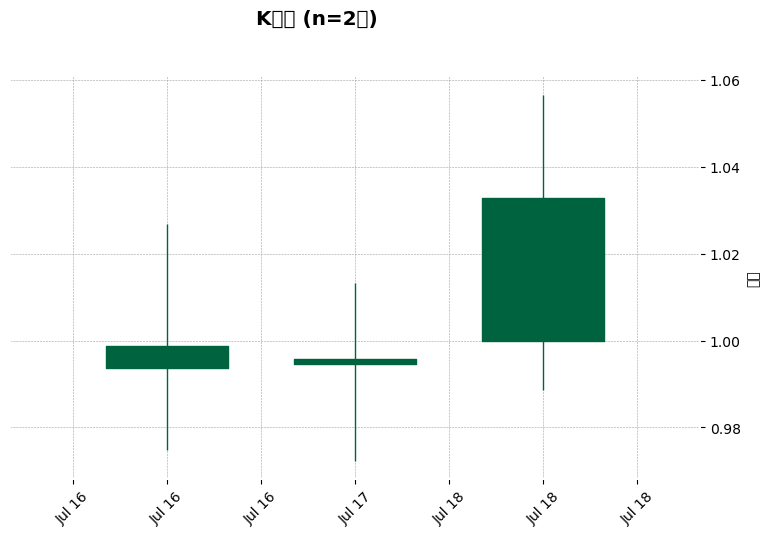

Processing dates: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1332/1332 [00:04<00:00, 289.27it/s]


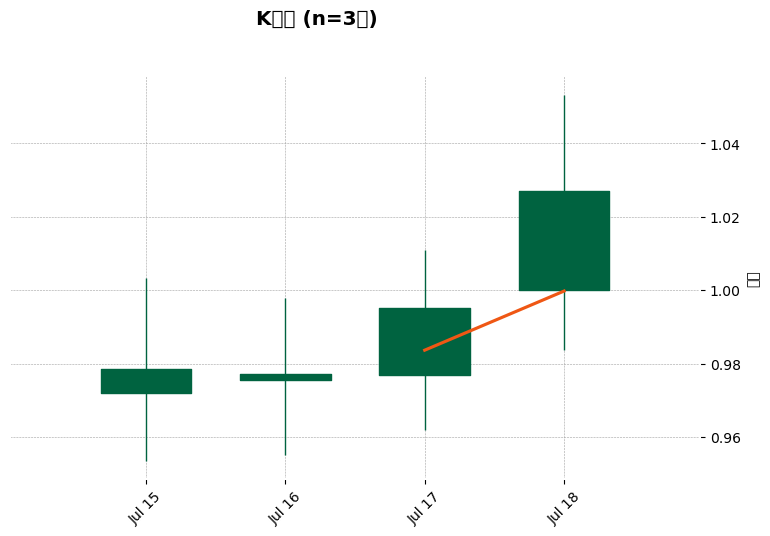

Processing dates: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1328/1328 [00:04<00:00, 316.37it/s]


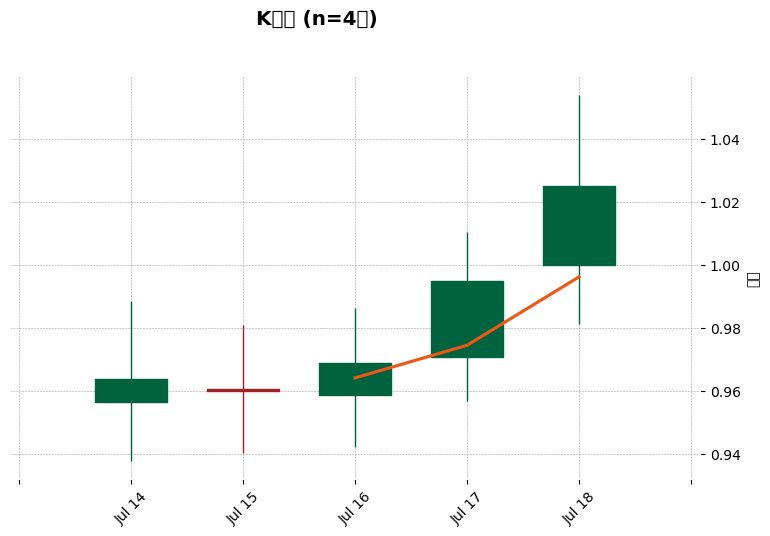

Processing dates: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1314/1314 [00:02<00:00, 492.46it/s]


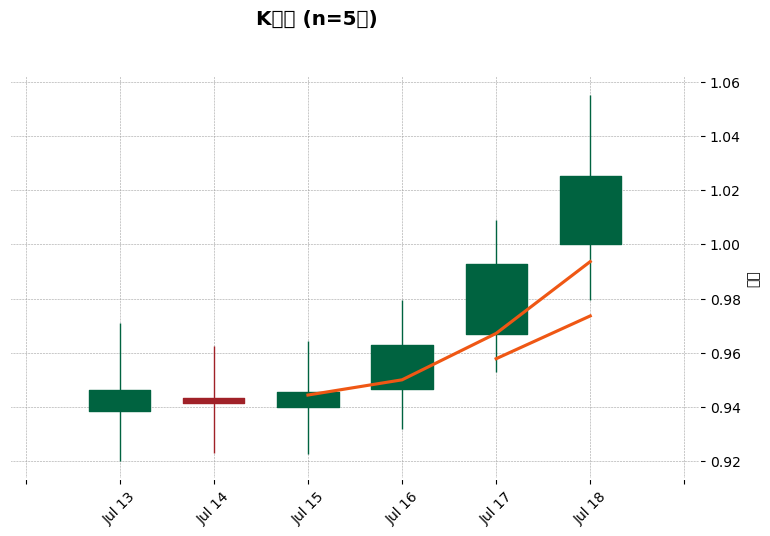

Processing dates: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1292/1292 [00:02<00:00, 481.25it/s]


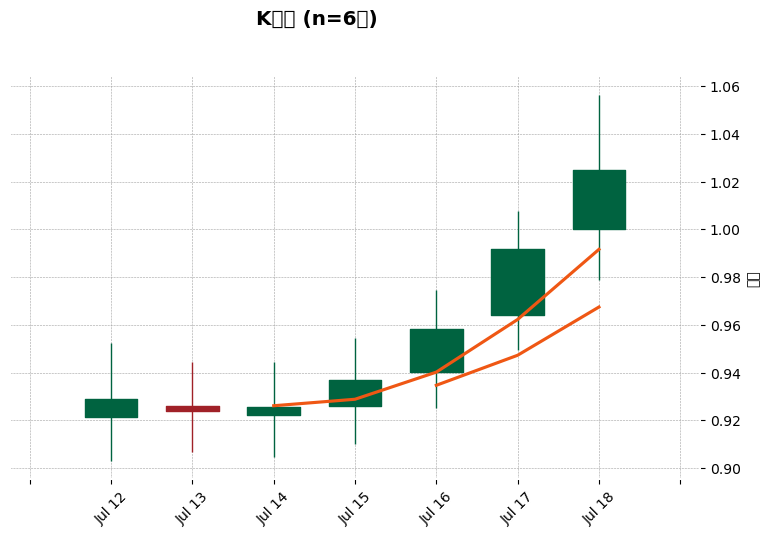

In [416]:
final_df_s = final_df.dropna()
for j in ['2','3','4','5','6']:
    filtered_df = final_df_s[final_df_s['platform_length'] == j]
    result = filtered_df.groupby('time').apply(take_top_p)
    anss = process_and_average(result,int(j),extract_data)
    anss = anss.rename(columns={
        'open': 'Open',
        'close': 'Close',
        'high': 'High',
        'low': 'Low'
    })

    # 2. 生成日期索引（假设从今天往前推）
    anss.index = pd.date_range(end=pd.Timestamp.today(), periods=len(anss), freq='D')[::1]
    mpf.plot(anss, 
         type='candle',  # 蜡烛图类型
         style='charles',  # 内置样式
         title='K线图 (n={}天)'.format(len(anss) - 1),
         ylabel='价格',
         volume=True if 'volume' in df.columns else False,  # 是否显示成交量
         figratio=(10, 6),  # 图像比例
         mav=(3, 5))

Processing dates: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1309/1309 [00:04<00:00, 304.78it/s]


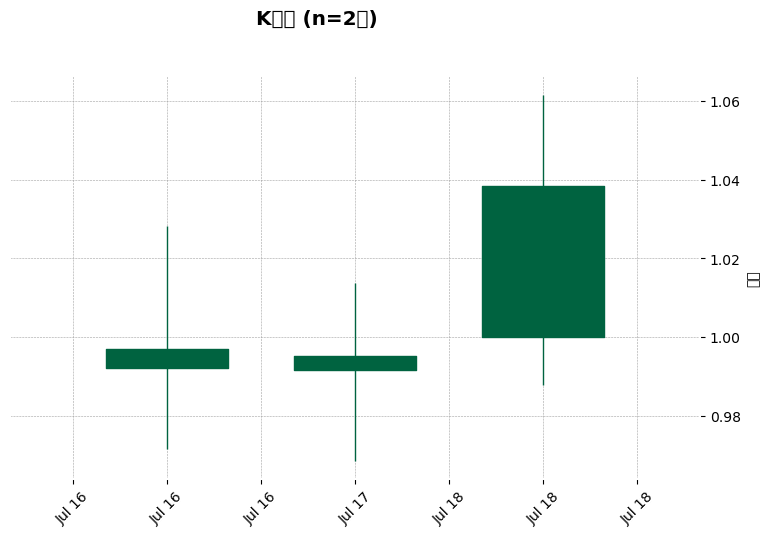

Processing dates: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1332/1332 [00:05<00:00, 246.58it/s]


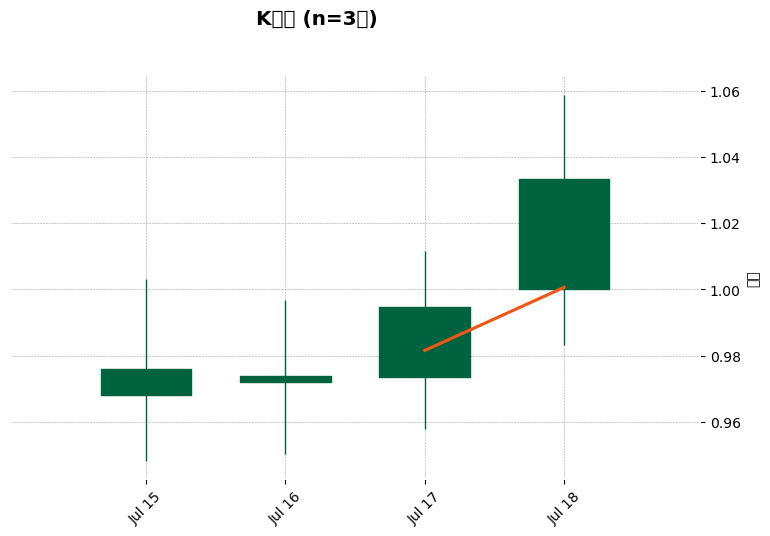

Processing dates: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1328/1328 [00:04<00:00, 319.21it/s]


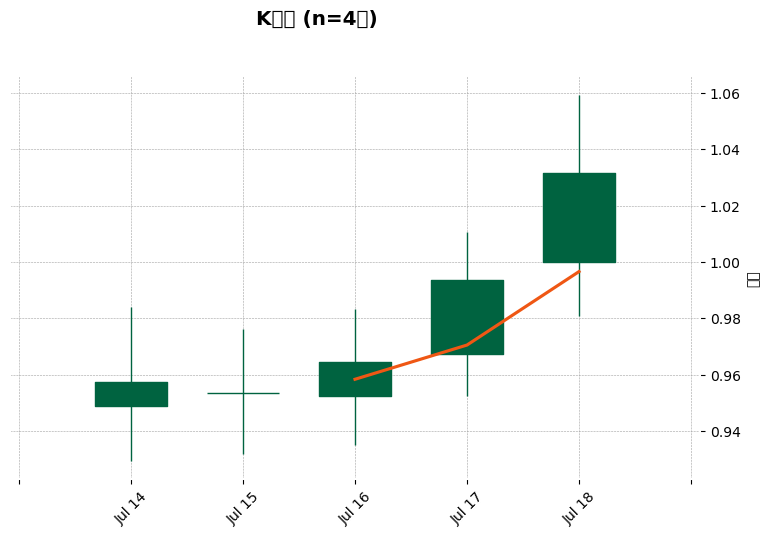

Processing dates: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1314/1314 [00:03<00:00, 347.72it/s]


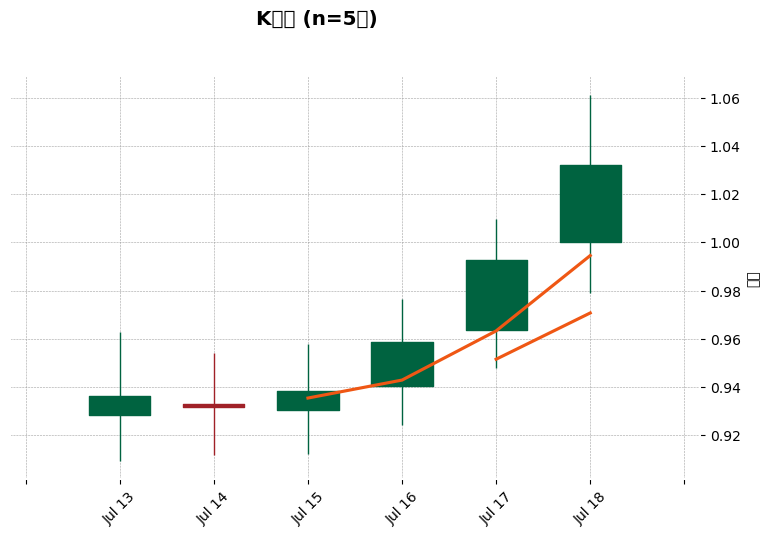

Processing dates: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1292/1292 [00:02<00:00, 579.82it/s]


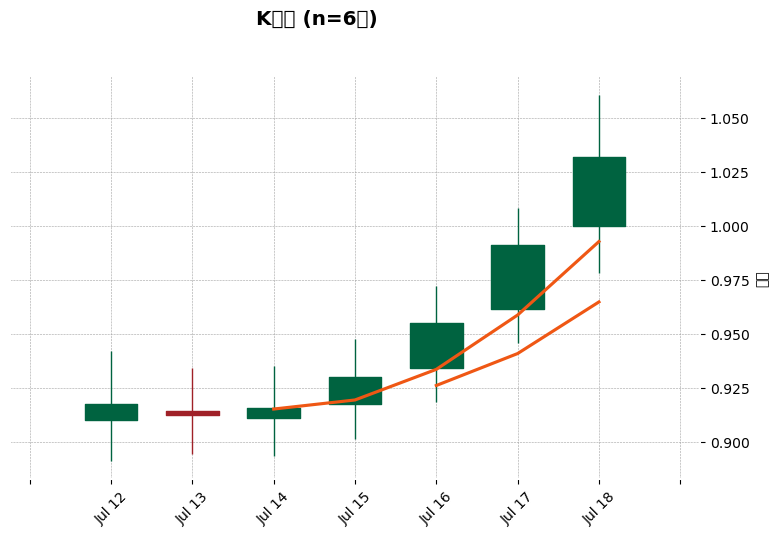

In [418]:
final_df_s = final_df.dropna()
for j in ['2','3','4','5','6']:
    filtered_df = final_df_s[final_df_s['platform_length'] == j]
    result = filtered_df.groupby('time').apply(take_bottom_p)
    anss = process_and_average(result,int(j),extract_data)
    anss = anss.rename(columns={
        'open': 'Open',
        'close': 'Close',
        'high': 'High',
        'low': 'Low'
    })

    # 2. 生成日期索引（假设从今天往前推）
    anss.index = pd.date_range(end=pd.Timestamp.today(), periods=len(anss), freq='D')[::1]
    mpf.plot(anss, 
         type='candle',  # 蜡烛图类型
         style='charles',  # 内置样式
         title='K线图 (n={}天)'.format(len(anss)  -1),
         ylabel='价格',
         volume=True if 'volume' in df.columns else False,  # 是否显示成交量
         figratio=(10, 6),  # 图像比例
         mav=(3, 5))

In [396]:
process_and_average(result,3,extract_data)

Processing dates: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1292/1292 [00:02<00:00, 461.92it/s]


,open,close,high,low
0,0.926019,0.936892,0.954284,0.910186
1,0.940118,0.958104,0.974694,0.925210
2,0.964142,0.991690,1.007777,0.949535
3,1.000000,1.025060,1.056429,0.978659


In [360]:
result

stock_id       time platform_length  daily_return
time                                                                  
2020-01-03 832370   600883.SH 2020-01-03               3      0.093023
           558245   300751.SZ 2020-01-03               3      0.083116
           750063   600499.SH 2020-01-03               3      0.068493
           223650   002428.SZ 2020-01-03               3      0.067488
           297189   002739.SZ 2020-01-03               3      0.062629
...                       ...        ...             ...           ...
2025-07-10 1173021  688800.SH 2025-07-10               3      0.018298
           172457   002221.SZ 2025-07-10               3      0.017951
           698056   600212.SH 2025-07-10               3      0.017900
           724173   600353.SH 2025-07-10               3      0.017290
           620125   301075.SZ 2025-07-10               3      0.016831

[27745 rows x 4 columns]

In [ ]:
df = shared_table[shared_table['stock_id'] == stock_id]

In [ ]:
'''
Task8:记突破平台的时间是0,根据平台长度分类绘制前n天K线图 观察形态 
'''

with Pool(96, initializer = init_worker, initargs=(long_table,)) as p:
    # 直接使用 stock_process，不需要 partial
    res_lst = list(tqdm(p.imap(stock_process, stock_list), total = len(stock_list)))  ##一个list 元素是每支股票的所有信号

final_df = pd.concat(res_lst, ignore_index=True)